# Env

In [ ]:
!pip install pandas numpy matplotlib torch torchmetrics transformers scikit-learn nltk seaborn praw

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import BertModel, BertTokenizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import seaborn as sns

import praw
import datetime
import time
import csv
import requests
import json
import multiprocessing
import os
from dateutil.relativedelta import relativedelta

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="praw")

In [14]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/train.tsv'
LOC = '/content/drive/MyDrive/Colab Notebooks/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Collect Historical Reddit Data
Using PullPushAPI to retrieve posts and PRAW for their comments from r/canada, r/OnGuardForThee and r/CanadaPolitics in the last year.


In [8]:
def store_data(data, filename):
  df = pd.DataFrame(data)
  filepath = os.path.join(LOC, filename)
  df.to_csv(filepath, sep='\t', index=False, mode='a', header=not os.path.exists(filepath))

## Retrieve posts within last year

### Collect

In [10]:
SUBREDDITS = ['canada', 'onguardforthee']
SCORE = 500
BEGIN_DATE_START = 1709251200
BEGIN_DATE_SPAN = 1711843200
END_DATE = 1740960000
QUERIES= ['liberals', 'conservatives', 'ndp']
SIZE = 100
DELAY_SEC = 3
DELAY_FATAL = 60
FILENAME = 'posts.tsv'

In [11]:
def get_posts(subreddit, score, start_date, end_date, query, size):
    PULLPUSH_URL = (
        f'https://api.pullpush.io/reddit/submission/search'
        f'?html_decode=True&subreddit={subreddit}&score=%3E{score}'
        f'&since={start_date}&until={end_date}&q={query}&size={size}'
    )
    response = requests.get(PULLPUSH_URL)

    if response.status_code == 200:
      return response.json()
    else:
      print(f'Request failed with status code {response.status_code}')
      print(response.text)
      return -1

def parse_posts(data):
  parsed = []
  data = data["data"]
  for post in data:
    parsed.append({
      "id": post["id"],
      "created_utc": datetime.datetime.utcfromtimestamp(post["created_utc"]).strftime('%Y-%m'),
      "subreddit": post["subreddit"],
      "title": post["title"],
    })
  return parsed

def update_timestamp(timestamp):
  dt = datetime.datetime.utcfromtimestamp(timestamp)
  updated_dt = dt + relativedelta(months=1)
  return int(updated_dt.timestamp())

total_tasks = len(SUBREDDITS) * len(QUERIES)
with tqdm(total=total_tasks, desc="Processing Subreddits and Queries") as pbar:
  current_date = BEGIN_DATE_START
  curr_span = BEGIN_DATE_SPAN
  while curr_span < END_DATE:
    for subreddit in SUBREDDITS:
      for query in QUERIES:
        data = get_posts(subreddit, SCORE, current_date, curr_span, query, SIZE)
        time.sleep(DELAY_SEC)
        if data == -1:
          print('Taking a 1 min break...')
          time.sleep(DELAY_FATAL)
          print('Trying again...')
          data = get_posts(subreddit, SCORE, current_date, curr_span, query, SIZE)
          if data == -1:
            break
        parsed = parse_posts(data)
        store_data(parsed, FILENAME)
    current_date = update_timestamp(current_date)
    curr_span = update_timestamp(curr_span)
    pbar.update(1)
  print("Data collection completed.")

Processing Subreddits and Queries: 12it [04:51, 24.27s/it]

Data collection completed.


### Pre-clean
Remove duplicate posts by ID. Posts with the same title in different subreddits are inherently unqiue.

In [15]:
filepath = os.path.join(LOC, FILENAME)
df = pd.read_csv(filepath, sep='\t')
df_clean = df.drop_duplicates(subset=['id'])
df_clean.to_csv(filepath, sep='\t', index=False)

## Retrieve comments for each post

In [58]:
KEYWORDS = [
    'justin trudeau', 'trudeau', 'pieere polievre', 'polievre', 'jagmeet singh', 'singh', 'elizabeth may',
    'mark carney', 'carney'
    'bloc quebecois', 'bloc', 'green party', 'greens', 'ndp', 'new democrats party'
    'liberal party of canada', 'liberal party', 'liberals', 'lpc',
    'conservative party of canada', 'conservative party', 'conservatives', 'cpc',
    'election', 'polls', 'policy', 'policies', 'rating'
]

reddit = praw.Reddit(
  client_id="wVcIHX1QOLw9KlL41lmc4Q",
  client_secret="cLN2rULYgw0pjOpt5_dxrK_d_8Uprw",
  user_agent="sentiment-analy by u/NecessaryAd803",
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Sanitization and Preperation
Removes stopwords, handles special characters, and applies stemming and lemmatization. Partitions iMBD data into training and test sets. Encodes numerically to make use of in NN. Tokenizes text into meaninful units and pads for uniform input length.

## Cleaning

In [8]:
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def normalize_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

def clean(df):
    tqdm.pandas(desc='Cleaning text')
    df['text'] = df['text'].progress_apply(clean_text)
    print(df.head())
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Splitting, Encoding, Tokenization
For use by LSTM and BERT models.

In [4]:
VOCAB_SIZE = 10000
MAX_LEN = 50
trunc_t = 'post'
pad_t = 'post'
oov_tok = '<OOV>'

In [9]:
def lsvc_split_encode(df):
  x = df['text']
  y = df['sentiment']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

  return x_train, x_test, y_train, y_test

def lstm_split_encode(df):
  x = df['text']
  y = df['sentiment']
  one = OneHotEncoder()
  y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

  return x_train, x_test, y_train, y_test

def lstm_tok_pad(x_train, x_test):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=oov_tok)
  tokenizer.fit_on_texts(x_train)

  x_train_seq = tokenizer.texts_to_sequences(x_train)
  x_test_seq = tokenizer.texts_to_sequences(x_test)

  x_train_pad = pad_sequences(x_train_seq, maxlen=MAX_LEN, padding=pad_t, truncating=trunc_t)
  x_test_pad = pad_sequences(x_test_seq, maxlen=MAX_LEN, padding=pad_t, truncating=trunc_t)

  return x_train_pad, x_test_pad

def bert_tok_pad(X_train, y_train):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  inputs = tokenizer(
      list(X_train),
      padding=True,
      truncation=True,
      max_length=128,
      return_tensors='pt'
  )
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  labels = torch.tensor(y_train)

  return input_ids, attention_mask, labels

# Define Sentiment Models
We utilize LSVC, LSTM and BERT in comparison. LSVC acts as the base model in this case.

## LSVC

In [9]:
def LSVCModel(x_train, y_train):
  vectorizer = TfidfVectorizer()
  lsvc_model = LinearSVC()
  model_pipeline = make_pipeline(vectorizer, lsvc_model)
  model_pipeline.fit(x_train, y_train)
  return model_pipeline

## RNN Model (LSTM)

In [68]:
def LSTMModel():
  model = Sequential()

  model.add(Embedding(VOCAB_SIZE, 32, input_length = MAX_LEN))
  model.add(LSTM(64))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  return model, early_stopping

# Training / Eval

In [10]:
df = pd.read_csv(TRAIN_PATH, sep='\t')
df.columns = ["sentiment", "text"]
df = clean(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleaning text: 100%|██████████| 32745/32745 [01:53<00:00, 288.90it/s]


   sentiment                                               text
0          1  realli slow catch movi like rocket fast enough...
1          1  controversi movi high rate prais understand wa...
2          1  movi tricki stori good actor done great act movi 
3          0  believ movi receiv award long slow move predic...
4          2  usual debat wether godfath goodfella better mf...


## LSVC

In [42]:
x_train, x_test, y_train, y_test = lsvc_split_encode(df)
model = LSVCModel(x_train, y_train)

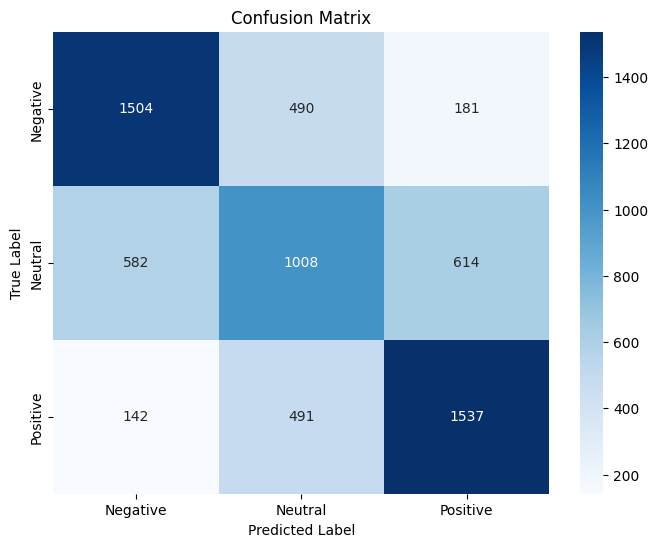

Accuracy: 0.6183
Precision: 0.6131
Recall: 0.6183
F1-Score: 0.6149


In [43]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## LSTM

In [69]:
x_train, x_test, y_train, y_test = lstm_split_encode(df)
x_train, x_test = lstm_tok_pad(x_train, x_test)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lstm = LSTMModel()
print(model.summary())

model = lstm[0]
early_stopping = lstm[1]
history = model.fit(x_train,y_train,epochs=15,batch_size=32,validation_split=0.1,callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 50, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,035,083 (3.95 MB)

 Trainable params: 345,027 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 690,056 (2.63 MB)

None
Epoch 1/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4153 - loss: 1.0408 - val_accuracy: 0.5683 - val_loss: 0.8754
Epoch 2/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6022 - loss: 0.8421 - val_accuracy: 0.5863 - val_loss: 0.8646
Epoch 3/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6714 - loss: 0.7424 - val_accuracy: 0.5763 - val_loss: 0.9036
Epoch 4/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7322 - loss: 0.6360 - val_accuracy: 0.5615 - val_loss: 0.9527
Epoch 5/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7757 - loss: 0.5489 - val_accuracy: 0.5618 - val_loss: 1.0617


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6087 - loss: 0.8523
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


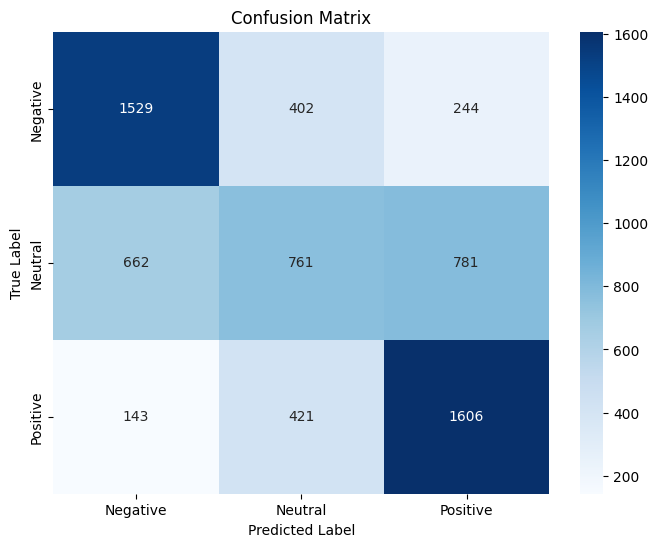

Accuracy: 0.5949
Precision: 0.5815
Recall: 0.5949
F1-Score: 0.5821


In [67]:
score = model.evaluate(np.asarray(x_test),np.asarray(y_test))
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Experiment

# Results

### Timeline Analysis of Sentiment

### Word Cloud and Timeline Analysis of Topics